stage 3

this notebook has three functions - 
1. get_fire_dates(fires) - get a list of dates from the FiresWithEuc dataframe
2. get_bbox(fire) - get the bounding boxes from the same dataframe - these are both complete and functioning 
3. def get_sat_images(bounds, dates, fires) - the previous two functions to query satelitte imagery 
 

In [1]:
#resources used
#https://stackoverflow.com/questions/6871016/adding-days-to-a-date-in-python

In [2]:
''' if stackstac version is not up to date run these in MPC terminal'''
#!pip install --upgrade stackstac==0.5.0
#"conda install -c conda-forge stackstac" 

' if stackstac version is not up to date run these in MPC terminal'

In [33]:
import datetime
import geopandas as gpd # 0.13.2
import stackstac # 0.5.0 
import dask.array as da #2023.5.0
from pystac_client import Client # 0.7.1 
import leafmap # 0.21.3
import pystac_client
import dask
import planetary_computer as pc # 0.5.1 
import geogif # 0.1.4
import numpy as np # 1.24.3
import xarray as xr # 2023.5.0
import rioxarray #0.14.1
import cartopy.crs as ccrs
import pyproj #3.6.0

In [20]:
import dask.array as da
from pystac_client import Client
import leafmap
from datetime import datetime
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import numpy as np
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import geojson
import json
import shapely
from geogif import dgif, gif
import pandas as pd

In [21]:
stackstac.__version__

'0.5.0'

In [22]:
#import shapfiles
EucList= gpd.read_file("Euc/EucInFires.shp")
FiresWithEuc = gpd.read_file("Fire/FiresWithEuc.shp")
EucList= EucList[EucList['Acres']>5]

In [23]:
#import matplotlib.pyplot as plt
#FiresWithEuc.explore("ALARM_DATE", legend=False)

In [24]:
# bounds for each bounding box
#FiresWithEuc.head(10).bounds

In [25]:
# Select observations in 'FireList' where 'FIRE_NAME' is in 'EucList'
FireList = FiresWithEuc[FiresWithEuc['FIRE_NAME'].isin(EucList['FIRE_NAME'])]
#FireList

# We notice that there are two seperate items named "Lakeville" in FiresList
# We will dissolve these into one
Fires_dissolved = FireList.dissolve(by='FIRE_NAME')
print(len(Fires_dissolved))
print(len(EucList))

13
13


In [26]:
# We need to do the same sorting and indexing with EucList
EucList_sorted = EucList.sort_values(by='FIRE_NAME')
Euc_set = EucList_sorted.set_index('FIRE_NAME')

In [27]:
# Change everything to 4326 and verify geometry is not in coordinates
EucAreas = Euc_set.to_crs(4326)
Fires_4326 = Fires_dissolved.to_crs(4326)

--------------------------------------------------

In [39]:
def get_fire_dates(fires):
    '''
    This function creates a list of alarm date for fires and calculates and outputs the date range for use in sat imagery queries
        start date - alarm date minus 30 days
        end date - alarm date plus 30 days
        
    args:
    fires: is a geodataframe that contains the column 'ALARM_DATE' (should be in "%Y-%m-%d") for each fire
        if you are using differnt data then you may need to change the column name 

    this will then be used for queries landsat satelitte images in a later function
    '''
    
    #create a list with the alarm_dates
    alarm_dates = fires['ALARM_DATE'] # you change the name of this column if using other data
    alarm_dates_list = list(alarm_dates)
    
    #lists to store start and end dates
    start_dates = []  
    end_dates = []    
    
    # Calculate start and end dates within 30 day month range
    for alarm_date in alarm_dates_list:
        datex = datetime.datetime.strptime(alarm_date, "%Y-%m-%d")
        
        # calculates and formats start dates
        start_date = datex - datetime.timedelta(days=90)
        start_date = start_date.strftime("%Y-%m-%d")
        
        # calculates and formats end dates
        end_date = datex + datetime.timedelta(days=730)
        end_date = end_date.strftime("%Y-%m-%d")
        
        #print(f"Alarm Date: {alarm_date}, Start Date: {start_date}, End Date: {end_date}")
        
        #appends list
        start_dates.append(start_date) 
        end_dates.append(end_date)
        
        
    
    return start_dates, end_dates   

#get_fire_dates(FiresWithEuc)
get_fire_dates(Fires_dissolved)

(['2017-07-11',
  '2020-05-18',
  '2020-10-21',
  '2020-06-29',
  '2004-03-27',
  '2019-07-25',
  '2020-03-07',
  '2017-07-10',
  '2017-07-10',
  '2022-03-25',
  '2004-02-09',
  '2008-03-22',
  '2017-07-10'],
 ['2019-10-09',
  '2022-08-16',
  '2023-01-19',
  '2022-09-27',
  '2006-06-25',
  '2021-10-22',
  '2022-06-05',
  '2019-10-08',
  '2019-10-08',
  '2024-06-22',
  '2006-05-09',
  '2010-06-20',
  '2019-10-08'])

------------------------------

In [36]:
def get_bbox(fire):
    '''
    This function returns a list containing the bbox for the geometry of each fire from the geometry column in a geodataframe
    
    args:
    fire : is a geodataframe that contains the geometry (polygon) for each fire
    '''
    #create dataframe with just coordinates of bbox as only column
    fire_bounds = fire.bounds #find bounds for each fire geometry
    fire_bounds['bbox'] = fire_bounds.apply(lambda row: (row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)
    bbox = fire_bounds['bbox'] 
    
    bbox= tuple(bbox) # ensures bbox is a tuple
    
    return bbox


In [83]:
 %%time 

def get_sat_images(bounds, dates, fires):
    '''
    This function gets image collections for each fire 
    
    args:
    bounds: list of bounding boxes 
    dates: two lists in one- the first is a list of dates that include the start date and end date for the range in query of sat images
    fires: 
    
    This function is designed to be used with the outputs of the previous two functions:
    dates = get_fire_dates(fires) contains two lists- start date is first list, end date is second 
    bounds = get_bbox(fire) 
    '''
    
    #set the start_dates, end_dates, and bboxbounds to be equal to the first two inputs of the function
    start_dates, end_dates = dates #get_fire_dates(FiresWithEuc)
    bboxs = bounds #get_bbox(FiresWithEuc)
    

    api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
    client = Client(cluster)
    client
    
    
    catalog = pystac_client.Client.open(api_url)
    
    
    ###################### transforms bbox from degrees to lat long - depending on your data this may or may not be necessary
    source_crs = 'epsg:3857' # coord system used by fireswitheuc
    target_crs = 'epsg:4326' # Global lat-lon coordinate system
    
    #create the transfromer
    latlon_to_s2_transformer = pyproj.Transformer.from_crs(source_crs, target_crs)
    
    
    projected_coordinates = [] # empty list to store new coordinates
    for point in bboxs:
        projected_minx, projected_miny = latlon_to_s2_transformer.transform(point[1], point[0])
        projected_maxx, projected_maxy = latlon_to_s2_transformer.transform(point[3], point[2])
        projected_coordinates.append((projected_minx, projected_miny, projected_maxx, projected_maxy)) #appends empty list
    
    # to make sure that the new projected coords are tuples
    bbox_new = tuple(projected_coordinates)

    #################################
    
    # interate through the start and end dates, and bboxes
    img_collect = [] #empty list to store image collections
    for i in range(len(fires)):
        search = catalog.search(
            datetime=f"{start_dates[i]}/{end_dates[i]}", 
            collections=["landsat-c2-l2"],
            bbox=bbox_new[i],  
            query=["eo:cloud_cover<5"],
            max_items=1000
        )
        
        #executes search and stores in variable, items
        items = pc.sign(search)
        img_collect.append(items) #stores collections in list, img_collect
        
        
    return img_collect 
    return bbox_new
   
        

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 33.1 µs


In [84]:
#defing new variables with results of previous functions
#boundingboxes= get_bbox(FiresWithEuc)
#fire_dates= get_fire_dates(FiresWithEuc)
boundingboxes= get_bbox(Fires_dissolved)
fire_dates= get_fire_dates(Fires_dissolved)

#executes get_sat_images for each search
#get_sat_images(boundingboxes, fire_dates, FiresWithEuc)
test = get_sat_images(boundingboxes, fire_dates, Fires_dissolved)

In [90]:
'''
part of my test
I am testing out the first collection in get_sat_images to make sure it has information in each collection
'''

#reproject the coords to be able to use them outside of my previous function
bboxx = get_bbox(Fires_dissolved)

source_crs = 'epsg:3857' # coord system used by fireswitheuc
target_crs = 'epsg:4326' # Global lat-lon coordinate system
    
#create the transfromer
latlon_to_s2_transformer = pyproj.Transformer.from_crs(source_crs, target_crs)
    
    
projected_coordinates = [] # empty list to store new coordinates
for point in bboxx:
    projected_minx, projected_miny = latlon_to_s2_transformer.transform(point[1], point[0])
    projected_maxx, projected_maxy = latlon_to_s2_transformer.transform(point[3], point[2])
    projected_coordinates.append((projected_minx, projected_miny, projected_maxx, projected_maxy)) #appends empty list
    
# to make sure that the new projected coords are tuples
bbox_new_1 = tuple(projected_coordinates)

In [86]:
#first item collection
test = test[1]
test

id: LC09_L2SP_015032_20220812_02_T1
"bbox: [-77.87957375, 39.23067498, -75.06821067, 41.41036502]"
gsd: 30
created: 2022-08-16T09:30:11.167072Z
sci:doi: 10.5066/P9OGBGM6
datetime: 2022-08-12T15:46:13.949944Z
platform: landsat-9
proj:epsg: 32618
"proj:shape: [7941, 7831]"
description: Landsat Collection 2 Level-2
"instruments: ['oli', 'tirs']"


In [87]:
stack = stackstac.stack(test, bounds_latlon=bbox_new_1[1])
stack.band
stack.sel(band=["nir08", "swir16", "red","blue","green"])

<xarray.DataArray 'stackstac-714d4cfad225ca872b20f7c3cedaad07' (time: 24,
                                                                band: 5,
                                                                y: 1183, x: 193)>
dask.array<getitem, shape=(24, 5, 1183, 193), dtype=float64, chunksize=(1, 1, 1024, 193), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2020-05-26T15:45:30.37...
    id                           (time) <U31 'LC08_L2SP_015032_20200526_02_T1...
  * band                         (band) <U13 'nir08' 'swir16' ... 'blue' 'green'
  * x                            (x) float64 3.703e+05 3.703e+05 ... 3.76e+05
  * y                            (y) float64 4.453e+06 4.453e+06 ... 4.418e+06
    instruments                  (time) object ['oli', 'tirs'] ... ['oli', 't...
    ...                           ...
    title                        (band) object 'Near Infrared Band 0.8' ... '...
    classification:bitfields     (band) object None None None None None
    common_name                  (band) object None None None None None
    center_wavelength            (band) object None None None None None
    full_width_half_max          (band) object None None None None None
    epsg                         int64 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(370260.0, 4417620.0, 376050.0...
    crs:         epsg:32618
    transform:   | 30.00, 0.00, 370260.00|\n| 0.00,-30.00, 4453110.00|\n| 0.0...
    resolution:  30.0

In [88]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

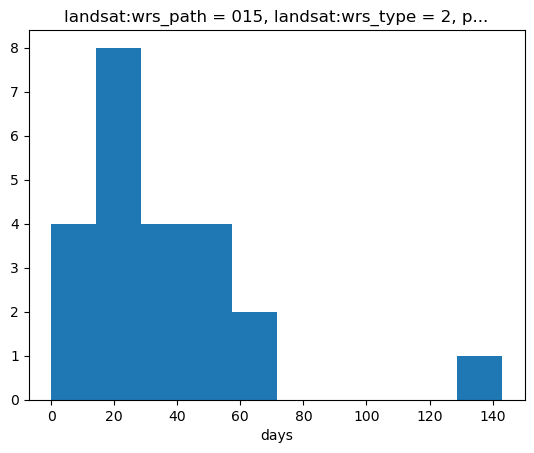

In [89]:
# yay it works!
qa = stack.sel(band="qa_pixel").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

# Check the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist();

In [60]:
#for i in range(len(test)):
 #   stack = stackstac.stack(test[i], bounds_latlon=bbox_new_1[i])
  #  stack.band
   # stack.sel(band=["nir08", "swir16", "red","blue","green"])
    


SyntaxError: 'return' outside function (3745643339.py, line 3)

------------------------------------------------------------